In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from dotenv import load_dotenv
from pandas.plotting import parallel_coordinates
import importlib
import plotly.express as px
import os
import glob
import pandas as pd
import json

import utils.db_tools as db_tools
from utils.db_tools import (
    db_init,
    filter_df,
    make_animation,
    get_data,
    metrics_grid,
    plot_grid,
    compute_metrics,
    plot_all_trajectories,
)

from classify import classify_trajectories

importlib.reload(db_tools)

<module 'utils.db_tools' from '/cluster/home/vogtva/pde-solvers-cuda/analysis/utils/db_tools.py'>

In [4]:
model = "bruss"
run_id = "ball_big"
df, output_dir = db_init(model, run_id)
# df = classify_trajectories(df)
# df["op"] = df["original_point"].astype(str)
# df["ic"] = df["initial_condition"].astype(str)
# df["op_A"] = df.original_point.apply(lambda op: str(op["A"])).astype(float)
# df["du_dv"] = df.original_point.apply(lambda op: str(op["Du"]) + str(op["Dv"]))
# df["ratio_b_a"] = df["B"] / df["A"]
# df["ic_type"] = df["initial_condition"].apply(lambda x: x.get("type"))
# # exclude A=5
# df = df[~np.isclose(df.op_A, 5.0)]

In [7]:
df.columns

Index(['model', 'A', 'B', 'Nx', 'dx', 'Nt', 'dt', 'Du', 'Dv',
       'initial_condition', 'random_seed', 'n_snapshots', 'filename', 'run_id',
       'original_point', 'mean_deviation', 'std_deviation', 'max_dx',
       'mean_dx', 'max_dt', 'mean_dt', 'dominant_power', 'total_power',
       'max_u', 'max_v', 'rel_std_u', 'rel_std_v'],
      dtype='object')

In [6]:
df["filename"]

0       /cluster/scratch/vogtva/data/bruss/ball_big/ad...
1       /cluster/scratch/vogtva/data/bruss/ball_big/0b...
2       /cluster/scratch/vogtva/data/bruss/ball_big/ee...
3       /cluster/scratch/vogtva/data/bruss/ball_big/57...
4       /cluster/scratch/vogtva/data/bruss/ball_big/76...
                              ...                        
7193    /cluster/scratch/vogtva/data/bruss/ball_big/c6...
7194    /cluster/scratch/vogtva/data/bruss/ball_big/44...
7195    /cluster/scratch/vogtva/data/bruss/ball_big/2f...
7196    /cluster/scratch/vogtva/data/bruss/ball_big/b2...
7197    /cluster/scratch/vogtva/data/bruss/ball_big/69...
Name: filename, Length: 7198, dtype: object

In [4]:
df.op_A.unique()

array([0.5, 2. , 1. , 1.5])

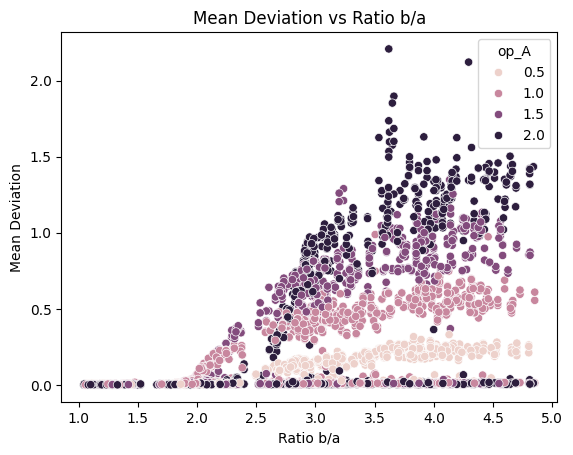

In [13]:
sns.scatterplot(data=df, x="ratio_b_a", y="dominant_power", hue="op_A")
plt.xlabel("Ratio b/a")
plt.ylabel("Mean Deviation")
plt.title("Mean Deviation vs Ratio b/a")
# plt.xscale('log')
# plt.yscale('log')
plt.show()

0.5


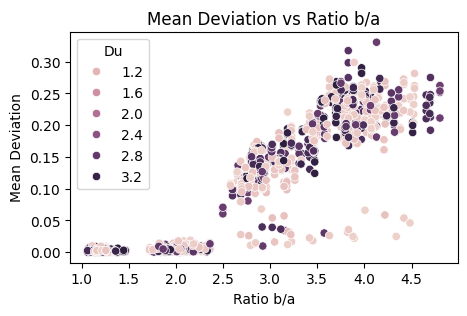

1.0


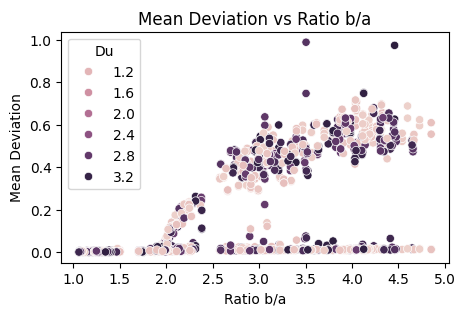

1.5


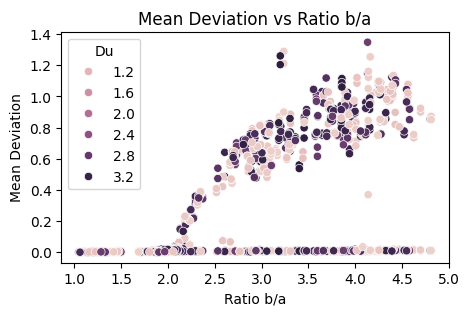

2.0


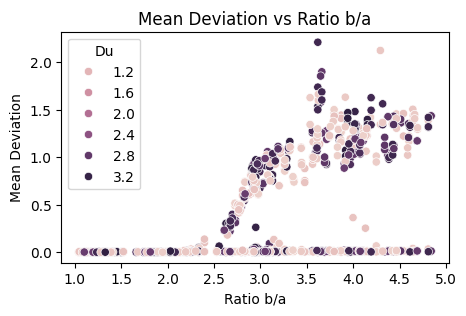

In [14]:
sns.set_palette("viridis")
for opA, df1 in df.groupby("op_A"):
    print(opA)
    plt.figure(figsize=(5, 3))
    sns.scatterplot(data=df1, x="ratio_b_a", y="dominant_power", hue="Du")
    plt.xlabel("Ratio b/a")
    plt.ylabel("Mean Deviation")
    plt.title("Mean Deviation vs Ratio b/a")
    # plt.xscale('log')
    # plt.yscale('log')
    plt.show()

In [30]:
df_filt = df[df.ic_type == "normal"]
df = df_filt

In [31]:
df["category"].value_counts()

category
OSC    1103
SS      444
DSS     246
INT      36
Name: count, dtype: int64

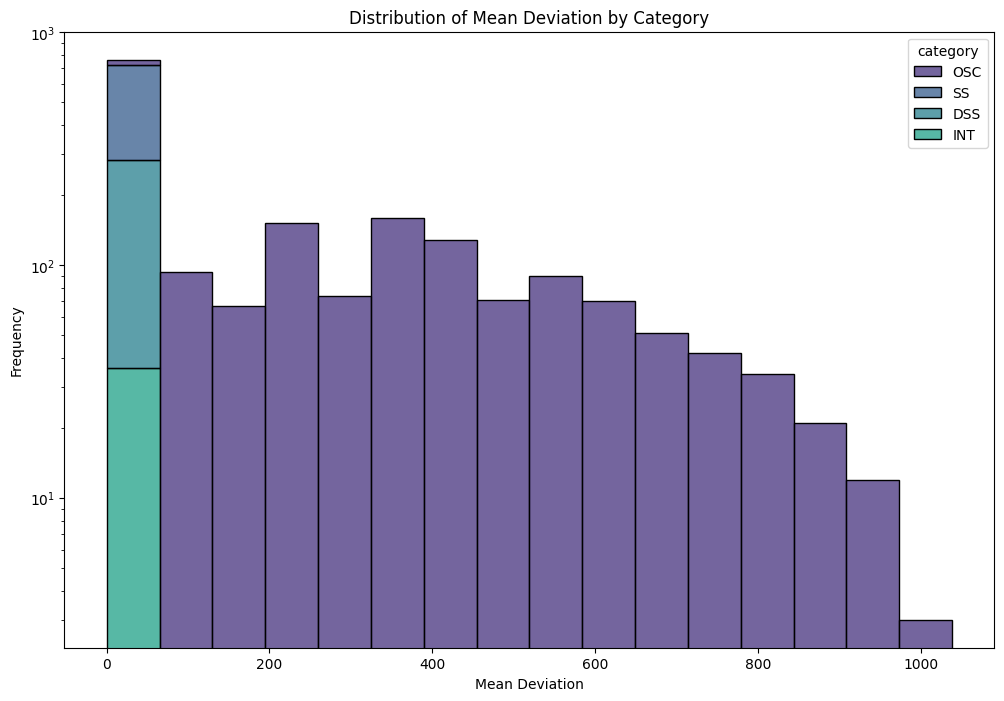

In [32]:
# Plot the distribution of mean_deviation' for each category
plt.figure(figsize=(12, 8))
ax = sns.histplot(data=df, x="mean_deviation", hue="category", multiple="stack")
ax.set(yscale="log")
plt.xlabel("Mean Deviation")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Deviation by Category")
plt.show()

In [33]:
fig = px.scatter(
    df,
    x="A",
    y="B",
    color="category",
    title="Scatter plot of A vs B",
    labels={"A": "A", "B": "B"},
    width=800,
    height=800,
)

fig.show()


In [34]:
# filter out all ops where there is only one category
for op, df1 in df.groupby("op"):
    if len(df1.value_counts("category")) == 1 or df1.value_counts("category").min() < 4:
        df = df[df["op"] != op]

In [35]:
points_of_interest = []
for op, df1 in df.groupby("op"):
    print(op, df1.value_counts("category").to_dict())
    points_of_interest.append(json.loads(op.replace("'", '"')))
df_int = pd.DataFrame(points_of_interest)
df_int.to_csv("varied_points.csv")

{'A': 0.5, 'B': 1.0, 'Du': 1, 'Dv': 4} {'SS': 22, 'DSS': 8}
{'A': 0.5, 'B': 1.0, 'Du': 3, 'Dv': 12} {'SS': 22, 'DSS': 8}
{'A': 0.5, 'B': 1.0, 'Du': 3, 'Dv': 54} {'SS': 26, 'DSS': 4}
{'A': 1.0, 'B': 1.25, 'Du': 1, 'Dv': 11} {'SS': 25, 'DSS': 5}
{'A': 1.0, 'B': 1.25, 'Du': 1, 'Dv': 4} {'SS': 22, 'DSS': 8}
{'A': 1.0, 'B': 1.25, 'Du': 3, 'Dv': 33} {'SS': 25, 'DSS': 5}
{'A': 1.0, 'B': 2.0, 'Du': 1, 'Dv': 4} {'OSC': 14, 'DSS': 12, 'INT': 4}
{'A': 1.0, 'B': 2.0, 'Du': 3, 'Dv': 54} {'OSC': 14, 'DSS': 8, 'INT': 8}
{'A': 1.5, 'B': 1.875, 'Du': 1, 'Dv': 18} {'SS': 24, 'DSS': 6}
{'A': 1.5, 'B': 3.0, 'Du': 1, 'Dv': 18} {'DSS': 26, 'SS': 4}
{'A': 1.5, 'B': 3.0, 'Du': 3, 'Dv': 33} {'DSS': 15, 'OSC': 6, 'SS': 5, 'INT': 4}
{'A': 2.0, 'B': 4.0, 'Du': 1, 'Dv': 11} {'SS': 20, 'DSS': 10}
{'A': 2.0, 'B': 4.0, 'Du': 3, 'Dv': 54} {'DSS': 15, 'SS': 15}


In [ ]:
df["op"] = df["original_point"].astype(str)
for _, df1 in df.groupby("op"):
    original_point = df1.iloc[0]["original_point"]
    print(original_point, df1.value_counts("category").to_dict())
    plot_ball_behavior(df1)

In [19]:
df_filt = df[df["original_point"] == "{'A': 1.0, 'B': 3.0, 'Du': 1, 'Dv': 18}"]
for ic, df1 in df_filt.groupby("category"):
    print(ic)
    plot_all_trajectories(df1, metric="dt")

DSS


INT


OSC


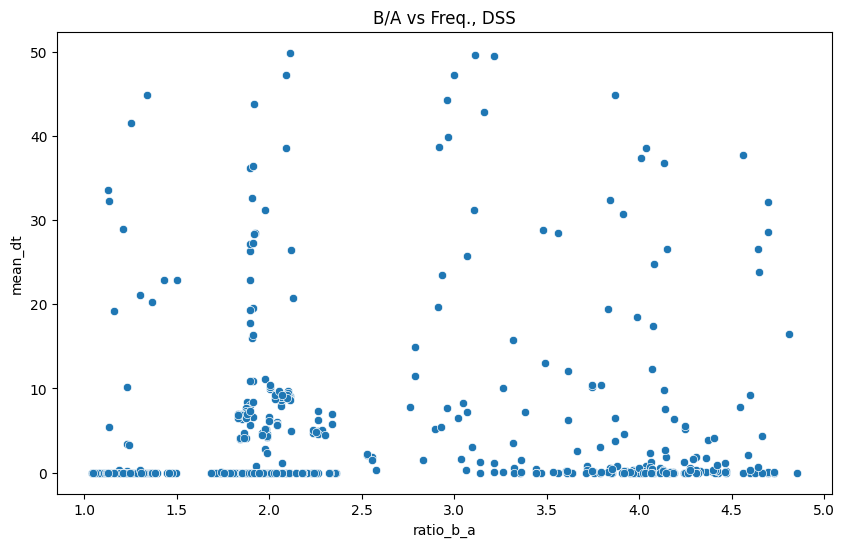

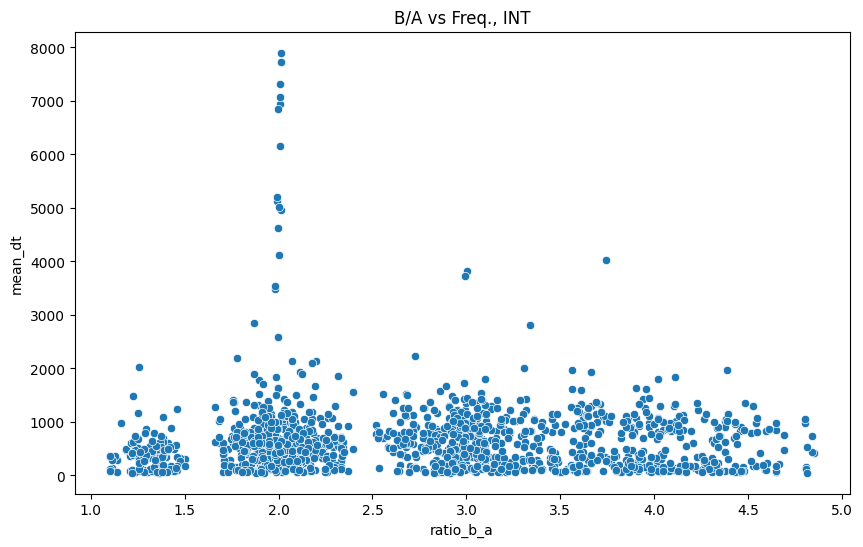

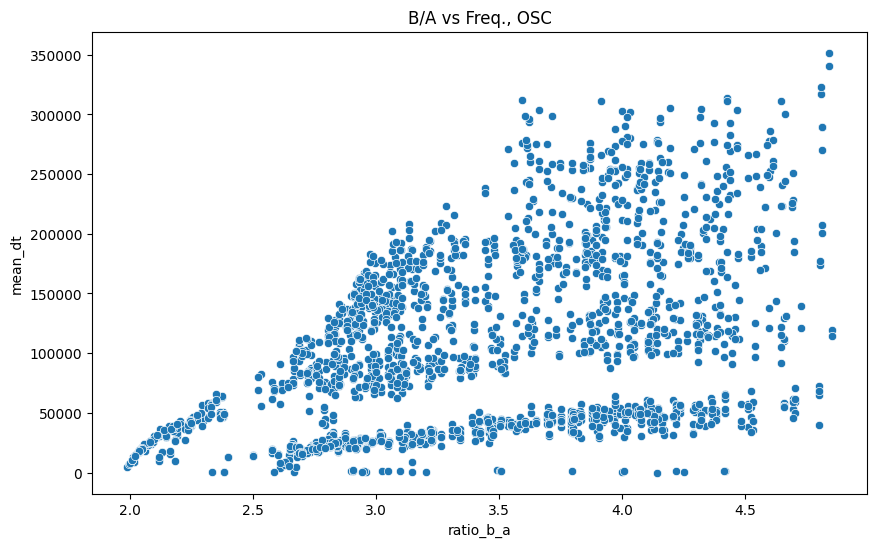

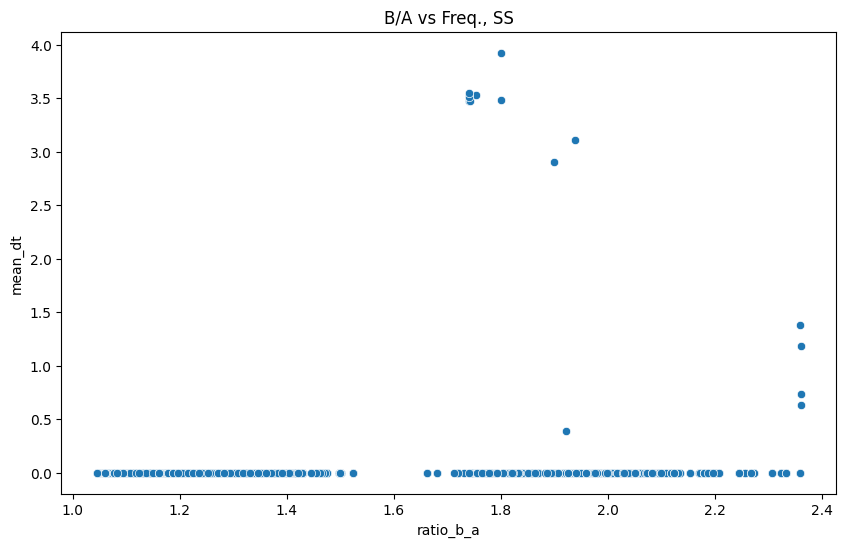

In [9]:
for cat, df1 in df.groupby("category"):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(df1, x="ratio_b_a", y="mean_dt")
    plt.title(f"B/A vs Freq., {cat}")
    plt.show()